In [1]:
import nmresearch as nmr # this loads data from brucker files 
import pickle # this loads data from saved numpy arrays

import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

In [2]:
# decent color schemes for plots and such

colors=['#d73027','#f46d43','#fdae61','#fee090','#ffffbf','#e0f3f8','#abd9e9','#74add1','#4575b4']
colors_single = ['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#fd8d3c','#f16913','#d94801','#a63603','#7f2704']
colors_single.reverse()

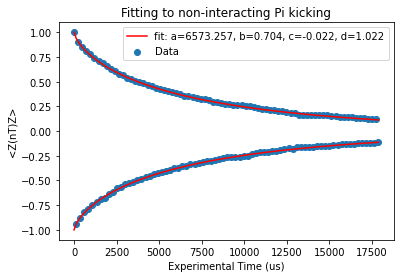

fitting std errors
[1.36709579e+02 1.06471836e-02 9.04775918e-03 1.26612724e-02]


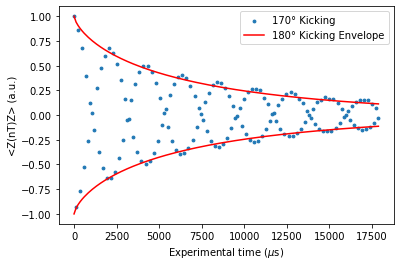

In [3]:
# 170 deg kicking

try:
    val_offres = pickle.load(open("nonint_170.dat", "rb"))
except (OSError, IOError) as e:
    val_offres=nmr.Experiment(328).tpc(add_spline=False)
    with open('nonint_170.dat', 'wb') as fi:
        pickle.dump(val_offres, fi)


# fitting to Pi-kicking
try:
    val_good = pickle.load(open("nonint_180.dat", "rb"))
except (OSError, IOError) as e:
    val_good=nmr.Experiment(358).tpc(add_spline=False)
    with open('nonint_180.dat', 'wb') as fi:
        pickle.dump(val_good, fi)


decay=abs(val_good)
x = np.arange(0,150)*120
def func(x, a, b, c, d):
    return d*np.exp(- (x / a) ** b ) + c

popt, pcov = curve_fit(func, x, decay, p0=[2000, 4/5, 0, 1])
perr = np.sqrt(np.diag(pcov))

plt.plot(x, func(x, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.plot(x, -func(x, *popt), 'r-')
plt.scatter(x, val_good,label="Data")
plt.title("Fitting to non-interacting Pi kicking")
plt.xlabel("Experimental Time (us)")
plt.ylabel("<Z(nT)Z>")
plt.legend()
plt.show()

print("fitting std errors")
print(perr)


# beating and fit

plt.scatter(x,val_offres,s=8,label="170\xb0 Kicking")
plt.plot(x, func(x, *popt), 'r-', label="180\xb0 Kicking Envelope")
plt.plot(x, -func(x, *popt), 'r-')
plt.legend()
plt.xlabel(r"Experimental time ($\mu$s)")
plt.ylabel(r"<Z(nT)Z> (a.u.)")
plt.savefig("nonint.pdf")
plt.show()

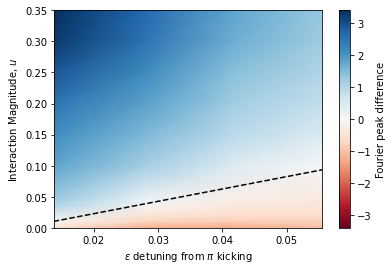

In [45]:
# Phase Diagram Plot

cnst2=[0,0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2,0.25,0.3,0.35]
kicks=np.arange(0,100)
freq = [i*(1/(len(kicks))) for i in range(len(kicks))]
theta = [160,165,170,175]
eps = [(180-ang)/360 for ang in theta]

res = np.zeros( (4,len(cnst2)) )
off_res = np.zeros( (4,len(cnst2)) )

# 160
try:
    vals160 = pickle.load(open("phase160.dat", "rb"))
except (OSError, IOError) as e:
    vals160=nmr.Experiment(393).load_tpc3d()
    with open('phase160.dat', 'wb') as fi:
        pickle.dump(vals160, fi)
        

fourier = np.array([abs(sp.fft.fft(val, norm="ortho")) for val in vals160])
off_res[0] = np.array([ft[44] for ft in fourier])
res[0] = np.array([ft[50] for ft in fourier])


# 165
try:
    vals165 = pickle.load(open("phase165.dat", "rb"))
except (OSError, IOError) as e:
    vals165=nmr.Experiment(402).load_tpc3d()
    with open('phase165.dat', 'wb') as fi:
        pickle.dump(vals165, fi)

fourier = np.array([abs(sp.fft.fft(val, norm="ortho")) for val in vals165])
off_res[1] = np.array([ft[46] for ft in fourier])
res[1] = np.array([ft[50] for ft in fourier])


# 170
try:
    vals170 = pickle.load(open("phase170.dat", "rb"))
except (OSError, IOError) as e:
    vals170=nmr.Experiment(391).load_tpc3d()
    with open('phase170.dat', 'wb') as fi:
        pickle.dump(vals170, fi)

fourier = np.array([abs(sp.fft.fft(val, norm="ortho")) for val in vals170])
off_res[2] = np.array([ft[47] for ft in fourier])
res[2] = np.array([ft[50] for ft in fourier])


# 175
vals175=nmr.Experiment(398).load_tpc3d()

try:
    vals175 = pickle.load(open("phase175.dat", "rb"))
except (OSError, IOError) as e:
    vals175=nmr.Experiment(398).load_tpc3d()
    with open('phase175.dat', 'wb') as fi:
        pickle.dump(vals175, fi)

fourier = np.array([abs(sp.fft.fft(val, norm="ortho")) for val in vals175])
off_res[3] = np.array([ft[49] for ft in fourier])
res[3] = np.array([ft[50] for ft in fourier])



Z = -1*(off_res-res)
Y=np.array([cnst2,cnst2,cnst2,cnst2])
X=np.array([eps for _ in range(12)]).transpose()


fig, ax = plt.subplots()
z_min, z_max = -np.abs(Z).max(), np.abs(Z).max()
c = ax.pcolormesh(X, Y, Z, cmap='RdBu', vmin=z_min, vmax=z_max,shading='gouraud')
fig.colorbar(c, ax=ax,label="Fourier peak difference")


xp = np.linspace(.0, .07, 100)
plt.plot(xp, xp*(1.987)-0.017,"k--", label="Boundary")
plt.xlabel(r"$\epsilon$ detuning from $\pi$ kicking")
plt.ylabel(r"Interaction Magnitude, $u$")
plt.xlim([eps[-1],eps[0]])
plt.ylim([0,0.35])

plt.savefig('smooth_phase_diag.pdf')

plt.show()

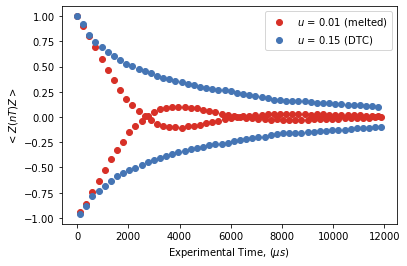

In [46]:
plt.scatter(np.array(kicks)*120,vals175[1],label=r"$u$ = {:.2f} (melted)".format(cnst2[1]),color=colors[0])


plt.scatter(np.array(kicks)*120,vals175[7],label=r"$u$ = {:.2f} (DTC)".format(cnst2[7]),color=colors[-1])
plt.legend()
plt.xlabel("Experimental Time, ($\mu s$)")
plt.ylabel("$<Z(nT)Z>$")
plt.savefig('intro_plot_v2.pdf')  
plt.show()

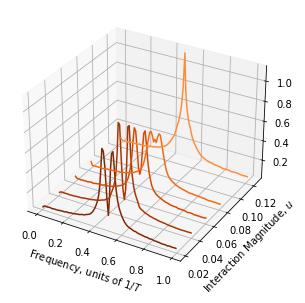

In [47]:
# internal Hamiltonain, Frequency domain

try:
    vals0ih = pickle.load(open("dtc_internal.dat", "rb"))
except (OSError, IOError) as e:
    vals0ih = nmr.Experiment(437).load_tpc3d()
    with open('dtc_internal.dat', 'wb') as fi:
        pickle.dump(vals0ih, fi)
    
kicks=np.array(list(range(vals0ih.shape[1])))
freq = [i*(1/(len(kicks))) for i in range(len(kicks))]
eps=(180-170)/360

cnst2=np.array([2.5, 5, 7.5, 10, 15, 30, 45, 60])/120

fourier = np.array([abs(sp.fft.fft(val, norm="ortho")) for val in vals0ih])

plt.figure(figsize=(5,5))

ax = plt.axes(projection='3d')

for idx, val in enumerate(cnst2[0:5]):
    xline = freq
    yline = [val for _ in range(len(freq))]
    zline = fourier[idx]
    ax.plot3D(xline, yline, zline, color=colors_single[idx])

plt.xlabel(r"Frequency, units of $1/T$")
plt.ylabel(r"Interaction Magnitude, $u$")
plt.savefig("period_double.pdf")
plt.show()

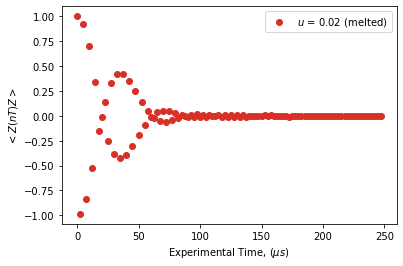

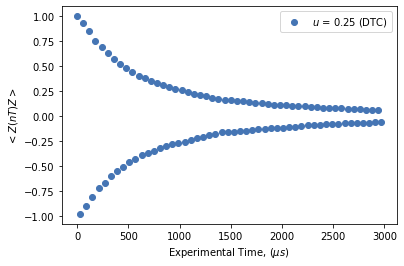

In [54]:
plt.scatter(kicks*cnst2[0]*120,vals0ih[0],label=r"$u$ = {:.2f} (melted)".format(cnst2[0]),color=colors[0])
plt.legend()
plt.xlabel("Experimental Time, ($\mu s$)")
plt.ylabel("$<Z(nT)Z>$")
plt.savefig("int_ham_melt.pdf")
plt.show()
plt.scatter(kicks*cnst2[5]*120,vals0ih[5],label=r"$u$ = {:.2f} (DTC)".format(cnst2[5]),color=colors[-1])
plt.legend()
plt.xlabel("Experimental Time, ($\mu s$)")
plt.ylabel("$<Z(nT)Z>$")
plt.savefig("int_ham_dtc.pdf")
plt.show()

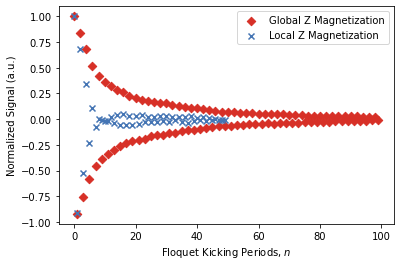

In [6]:
# Local v Global Plot

try:
    vals_local = pickle.load(open("local_dtc.dat", "rb"))
except (OSError, IOError) as e:
    vals_local=nmr.Experiment(455).load_tpc3d()
    with open('local_dtc.dat', 'wb') as fi:
        pickle.dump(vals_local, fi)
        
try:
    vals_global = pickle.load(open("global_dtc.dat", "rb"))
except (OSError, IOError) as e:
    vals_global=nmr.Experiment(451).load_tpc3d()
    with open('global_dtc.dat', 'wb') as fi:
        pickle.dump(vals_global, fi)

plt.scatter(list(range(100)), vals_global[10], label=r"Global Z Magnetization",color=colors[0],marker="D")
plt.scatter(list(range(50)), vals_local[10], label=r"Local Z Magnetization",color=colors[-1],marker="x")
plt.legend()
plt.xlabel(r"Floquet Kicking Periods, $n$")
plt.ylabel(r"Normalized Signal (a.u.)")
plt.savefig('local_v_global_1.pdf')  
plt.show()

In [9]:
# various Z fields at 170 degree kicking

cnst2_first=[0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]

try:
    vals0 = pickle.load(open("dtc170z0_v1.dat", "rb"))
except (OSError, IOError) as e:
    vals0=nmr.Experiment(447).load_tpc3d()
    with open('dtc170z0_v1.dat', 'wb') as fi:
        pickle.dump(vals0, fi)

cnst2_rest=[0,0.01,0.02,0.03,0.04,0.05,0.1,0.15,0.2,0.25,0.3,0.35]

try:
    vals45 = pickle.load(open("dtc170z45_v1.dat", "rb"))
except (OSError, IOError) as e:
    vals45=nmr.Experiment(408).load_tpc3d()
    with open('dtc170z45_v1.dat', 'wb') as fi:
        pickle.dump(vals45, fi)
        
try:
    vals90 = pickle.load(open("dtc170z90_v1.dat", "rb"))
except (OSError, IOError) as e:
    vals90=nmr.Experiment(407).load_tpc3d()
    with open('dtc170z90_v1.dat', 'wb') as fi:
        pickle.dump(vals90, fi)
        
try:
    vals135 = pickle.load(open("dtc170z135_v1.dat", "rb"))
except (OSError, IOError) as e:
    vals135=nmr.Experiment(419).load_tpc3d()
    with open('dtc170z135_v1.dat', 'wb') as fi:
        pickle.dump(vals135, fi)
        
try:
    vals180 = pickle.load(open("dtc170z180_v1.dat", "rb"))
except (OSError, IOError) as e:
    vals180=nmr.Experiment(414).load_tpc3d()
    with open('dtc170z180_v1.dat', 'wb') as fi:
        pickle.dump(vals180, fi)
        
def two_timescale_fit(vals,cut,phi,save=None):
    
    y=-np.log(abs(vals))
    x=list(range(len(vals)))
   
    plt.scatter(x[0:cut],y[0:cut],s=4)
    p1 = np.polyfit(x[0:cut],y[0:cut],1)
    x1 = np.arange(0,x[cut],.1)
    f1 = p1[0]*x1+p1[1]
    plt.plot(x1,f1,label=r"$\tau_1$ = {:.2f}".format(1/p1[0]))

    plt.scatter(x[cut:-1],y[cut:-1],s=4)
    p2 = np.polyfit(x[cut:-1],y[cut:-1],1)
    x2 = np.arange(x[cut],x[-1],1)
    f2 = p2[0]*x2+p2[1]
    plt.plot(x2,f2,label=r"$\tau_2$ = {:.2f}".format(1/p2[0]))

    plt.legend()
    plt.title(r"Fitting to Prethermal $U(1)$ DTC, $hT={}$".format(phi))
    plt.xlabel(r"Floquet Kicking Periods, $n$")
    plt.ylabel(r"$-\log(|<Z(nT)Z>|)$")
    if save is not None:
        plt.savefig(save+".pdf")
    plt.show()

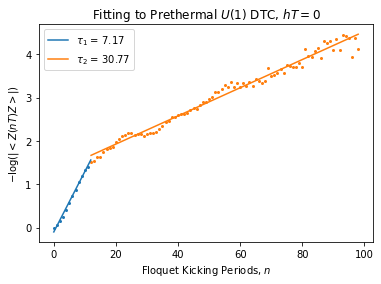

In [10]:
two_timescale_fit(vals0[2],12,0,"fit_ht0")

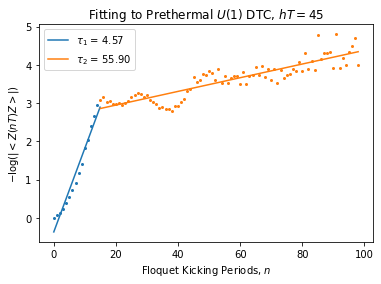

In [11]:
two_timescale_fit(vals45[5],15,45,"fit_ht45")

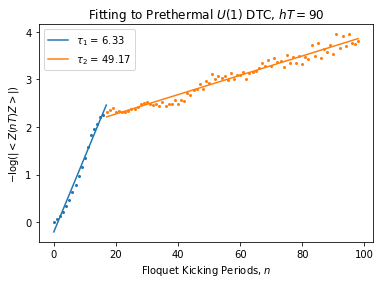

In [12]:
two_timescale_fit(vals90[5],17,90,"fit_ht90")

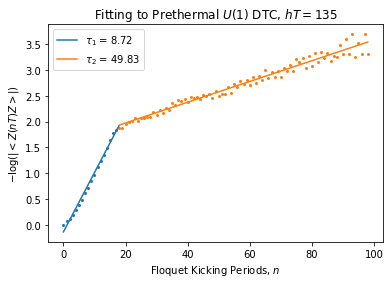

In [13]:
two_timescale_fit(vals135[4],18,135,"fit_ht135")

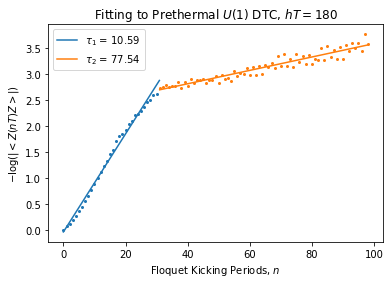

In [14]:
two_timescale_fit(vals180[2],31,180,"fit_ht180")

In [ ]:
x_fit = []
y_fit = []
kicks=list(range(100))
cut=12
for idx in range(2,len(cnst2_first)):
    x_fit.extend(kicks[0:cut])
    y_fit.extend(-np.log(abs(vals0[idx,0:cut])))
p = np.polyfit(x_fit,y_fit,1)
x1 = np.arange(0,kicks[cut],.1)
f1 = p[0]*x1+p[1]

for idx in range(2,len(cnst2_first),2):
    plt.scatter(kicks[0:cut],-np.log(abs(vals0[idx,0:cut])),label=cnst2_first[idx], color=colors_single[int(idx/2)],s=8)

x=np.arange(0,cut,.1)
plt.plot(x1,f1,'k--',linewidth=2.5)
plt.legend()
plt.xlabel(r"Floquet Kicking Periods, $n$")
plt.ylabel(r"$-\log(|<Z(nT)Z>|)$")
#plt.title(r"Fitting to Prethermal U(1) DTC, $hT=0$, various $u$")
plt.savefig("early_fit.pdf")
plt.show()

In [ ]:
p2 = np.polyfit(x[cut:-1],y[cut:-1],1)
x2 = np.arange(x[cut],x[-1],1)
f2 = p2[0]*x2+p2[1]

for idx in range(2,len(cnst2_first),2):
    plt.scatter(kicks[cut:-1], -np.log(abs(vals0[idx,cut:-1])),label=cnst2_first[idx], color=colors_single[int(idx/2)],s=8)

x=np.arange(cut,100,.1)
plt.plot(x,x*p2[0]+p2[1]+.25,'k-.',linewidth=2)
plt.plot(x,x*p2[0]+p2[1]-.8,'k-.',linewidth=2)
plt.legend()
plt.xlabel(r"Floquet Kicking Periods, $n$")
plt.ylabel(r"$-\log(|<Z(nT)Z>|)$")
#plt.title(r"Fitting to Prethermal U(1) DTC, $hT=0$, various $u$")
plt.savefig("late_fit.pdf")
plt.show()

In [15]:
# variable epsilon, variable z-field

cnst2 = [0.0, 0.02, 0.04, 0.06, 0.08, 0.10]
theta = [175, 170, 165]
eps = [(180-ang)/360 for ang in theta]

try:
    vals175z0 = pickle.load(open("dtc175z0.dat", "rb"))
except (OSError, IOError) as e:
    vals175z0=nmr.Experiment(549).load_tpc3d()
    with open('dtc175z0.dat', 'wb') as fi:
        pickle.dump(vals175z0, fi)

try:
    vals175z90 = pickle.load(open("dtc175z90.dat", "rb"))
except (OSError, IOError) as e:
    vals175z90=nmr.Experiment(550).load_tpc3d()
    with open('dtc175z90.dat', 'wb') as fi:
        pickle.dump(vals175z90, fi)
        
try:
    vals175z180 = pickle.load(open("dtc175z180.dat", "rb"))
except (OSError, IOError) as e:
    vals175z180=nmr.Experiment(553).load_tpc3d()
    with open('dtc175z180.dat', 'wb') as fi:
        pickle.dump(vals175z180, fi)
        
try:
    vals170z0 = pickle.load(open("dtc170z0.dat", "rb"))
except (OSError, IOError) as e:
    vals170z0=nmr.Experiment(554).load_tpc3d()
    with open('dtc170z0.dat', 'wb') as fi:
        pickle.dump(vals170z0, fi)
        
try:
    vals170z90 = pickle.load(open("dtc170z90.dat", "rb"))
except (OSError, IOError) as e:
    vals170z90=nmr.Experiment(561).load_tpc3d()
    with open('dtc170z90.dat', 'wb') as fi:
        pickle.dump(vals170z90, fi)
        
try:
    vals170z180 = pickle.load(open("dtc170z180.dat", "rb"))
except (OSError, IOError) as e:
    vals170z180=nmr.Experiment(562).load_tpc3d()
    with open('dtc170z180.dat', 'wb') as fi:
        pickle.dump(vals170z180, fi)
        
try:
    vals165z0 = pickle.load(open("dtc165z0.dat", "rb"))
except (OSError, IOError) as e:
    vals165z0=nmr.Experiment(565).load_tpc3d()
    with open('dtc165z0.dat', 'wb') as fi:
        pickle.dump(vals165z0, fi)
        
try:
    vals165z90 = pickle.load(open("dtc165z90.dat", "rb"))
except (OSError, IOError) as e:
    vals165z90=nmr.Experiment(566).load_tpc3d()
    with open('dtc165z90.dat', 'wb') as fi:
        pickle.dump(vals165z90, fi)
        
try:
    vals165z180 = pickle.load(open("dtc165z180.dat", "rb"))
except (OSError, IOError) as e:
    vals165z180=nmr.Experiment(565).load_tpc3d()
    with open('dtc165z180.dat', 'wb') as fi:
        pickle.dump(vals165z180, fi)

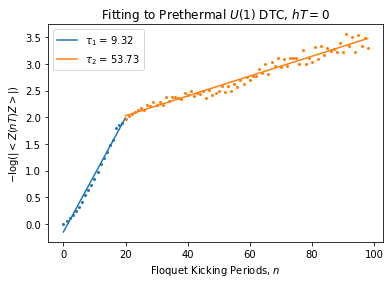

In [16]:
two_timescale_fit(vals175z0[2],20,0)

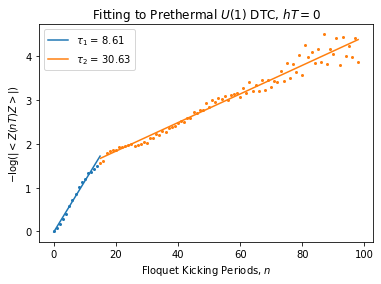

In [17]:
two_timescale_fit(vals170z0[4],15,0)

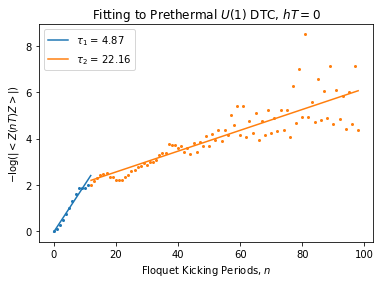

In [18]:
two_timescale_fit(vals165z0[5],12,0)

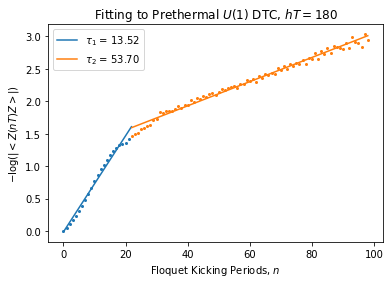

In [19]:
two_timescale_fit(vals175z180[2],22,180)

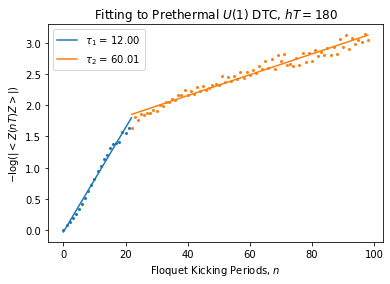

In [20]:
two_timescale_fit(vals170z180[2],22,180)

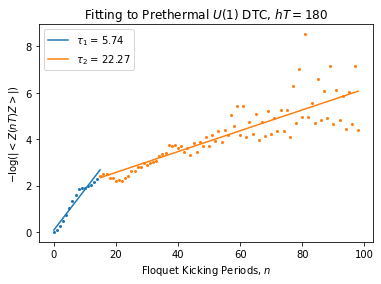

In [21]:
two_timescale_fit(vals165z180[5],15,180)